In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
magnetic.shape

(1533537, 11)

In [8]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [9]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [10]:
train = pd.concat([train, train_1], axis=1)
test = pd.concat([test, test_1], axis=1)


In [11]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [12]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [13]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [14]:
train = train.merge(potential, on=['molecule_name'], how='left')
test = test.merge(potential, on=['molecule_name'], how='left')

In [15]:
scaler.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd',
       'pso', 'dso'],
      dtype='object')

In [16]:
y = train['potential_energy']

In [17]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [18]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [19]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x        ...         cos_f1  cos_center0  cos_center1  \
0  0.0019760   2.2   0.43        ...         1.0000      -1.0000  -0.00000083   
1  0.0019760   2.2   0.43        ...         0.5005      -0.8164   0.81740000   
2  0.0019760   2.2   0.43        ...         0.5005      -0.8170   0.81700000   
3  0.0019760   2.2   0.43        ...         0.9995      -0.8164   0.81640000   
4  0.0002766   2.2   0.43        ...        -0.3335      -1.0010  -0.00005250   

   atom_n     molecule_name        fc              sd           pso  \
0       4  dsgdb9nsd_000001  83.00000  0.254638671875  1.2587890625   
1       4  dsgdb9nsd_000001 -11.03125  0.353027343750  2.8574218750   
2       4  dsgdb9nsd_000001 -11.03125  0.353027343750  2.8593750000   
3       4  dsgdb9nsd_000001 -11.03125  0.353027343750  2.8593750000   
4       4  dsgdb9nsd_000001  83.00000  0.254638671875  1.2587890625   

             dso  potential_energy  
0  0.27197265625         -40.53125  
1 -3.43359375000         -40.53125  
2 -3.43359375000         -40.53125  
3 -3.43359375000         -40.53125  
4  0.27197265625         -40.53125  

[5 rows x 121 columns]

In [20]:
train.shape

(4658147, 121)

In [21]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'seed': 666,
          'colsample_bytree': 1.0
         }

In [22]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [23]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'potential_energy',
       'pso', 'dso']]

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 3000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=100)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 5.05915	valid_1's l1: 5.58173
[1000]	training's l1: 3.8151	valid_1's l1: 4.62612
[1500]	training's l1: 3.0914	valid_1's l1: 4.10943
[2000]	training's l1: 2.60257	valid_1's l1: 3.79124
[2500]	training's l1: 2.23134	valid_1's l1: 3.55517
[3000]	training's l1: 1.94678	valid_1's l1: 3.38664
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 1.94678	valid_1's l1: 3.38664
Fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 5.05084	valid_1's l1: 5.57946
[1000]	training's l1: 3.80001	valid_1's l1: 4.61347
[1500]	training's l1: 3.08178	valid_1's l1: 4.10173
[2000]	training's l1: 2.59138	valid_1's l1: 3.77845
[2500]	training's l1: 2.2209	valid_1's l1: 3.54531
[3000]	training's l1: 1.9335	valid_1's l1: 3.37362
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 1.9335	valid_1's l1: 3.37362
Fold 3
Training until validation scores don

[500]	training's l1: 5.15904	valid_1's l1: 6.21533
[1000]	training's l1: 3.7146	valid_1's l1: 5.31628
[1500]	training's l1: 2.88297	valid_1's l1: 4.86967
[2000]	training's l1: 2.31074	valid_1's l1: 4.57327
[2500]	training's l1: 1.90098	valid_1's l1: 4.38901
[3000]	training's l1: 1.5904	valid_1's l1: 4.26139
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 1.5904	valid_1's l1: 4.26139
Fold 4
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 5.15263	valid_1's l1: 6.18313
[1000]	training's l1: 3.74027	valid_1's l1: 5.33679
[1500]	training's l1: 2.90189	valid_1's l1: 4.89205
[2000]	training's l1: 2.3402	valid_1's l1: 4.62629
[2500]	training's l1: 1.92645	valid_1's l1: 4.44489
[3000]	training's l1: 1.60694	valid_1's l1: 4.30883
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 1.60694	valid_1's l1: 4.30883
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 5.12719	valid_1's l1:

[1000]	training's l1: 3.74935	valid_1's l1: 4.78483
[1500]	training's l1: 2.94617	valid_1's l1: 4.2177
[2000]	training's l1: 2.40673	valid_1's l1: 3.85642
[2500]	training's l1: 2.01509	valid_1's l1: 3.60366
[3000]	training's l1: 1.72286	valid_1's l1: 3.43116
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 1.72286	valid_1's l1: 3.43116
Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 3.56784	valid_1's l1: 5.38698
[1000]	training's l1: 2.15783	valid_1's l1: 4.65188
[1500]	training's l1: 1.44878	valid_1's l1: 4.3318
[2000]	training's l1: 1.031	valid_1's l1: 4.18638
[2500]	training's l1: 0.758172	valid_1's l1: 4.10378
[3000]	training's l1: 0.5691	valid_1's l1: 4.04783
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.5691	valid_1's l1: 4.04783
Fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 3.58536	valid_1's l1: 5.31342
[1000]	training's l1: 2.17332	valid_1's l1:

In [33]:
predictions

array([-247.5642457 , -251.00621249, -301.23662501, ..., -389.41074477,
       -399.99749084, -394.39225237])

In [34]:
test.shape

(2505542, 117)

In [35]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [36]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [37]:
sub.shape

(2505542, 2)

In [38]:
len(predictions)

2505542

In [39]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.2.7.csv", index=False)

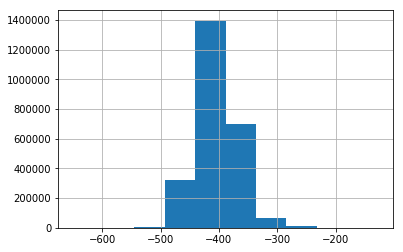

In [40]:
sub['scalar_coupling_constant'].hist()

In [41]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.2.7.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.2.7.csv', index=False)